*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module02_02_more_nearest_neighbors.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
from matplotlib import pylab as plt

# Nearest neighbor classification

Recall the nearest neighbor classifier:

*Nearest neighbor classifier*

* Find the example in the training data that is closest to
  the example that needs to be classified.
* Return its label.

In [2]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, x):
        distances = [distance(x, self.X[i]) for i in range(len(self.X))]
        return np.argmin(distances)
    def predict(self, x) :
        return self.y[self.get_nearest(x)]

In what follows we make some observations regarding the nearest neighbor classifier.

### Running time

Predicting the class of a given input requires iteration over the entire training set of $N$ training examples.  Each step requires the computation of the distance to some training example, which requires time proportional to the number of dimensions.  In CS-speak, we say that it is $O(d)$ (see e.g. this article on [big-O notation](https://en.wikipedia.org/wiki/Big_O_notation)).  Therefore, the overall running time for classifying a single input is proportional to $N\cdot d$, i.e. is $O(N\cdot d)$.  This can be expensive for large training sets sets.  If you need to classify a large test dataset, you also need to multiply by its size, making things even worse!  Compare this to the time necessary to classify an input using the perceptron algorithm:  this consists of simply computing a dot product, which takes time proportional to the dimensionality of the data, i.e. is $O(d)$.


### Pros and cons of nearest neighbor classification

#### Pros

* Simple to understand and implement
* Trivial to train
* Works for just about any learning problem:  classification, regression etc.
* Highly expressive - decision boundary is not limited to any particular form
* Easy to explain the results

#### Cons

* Expensive during testing
* Accuracy can be low for high dimensional data; usually not the best performing classifier

The drawbacks of the nearest neighbor classifier can be addressed to some extent as described next.


### Improving the running time of nearest neighbor methods

Solutions for improving the running time:

* Condensing the dataset:  Retain only a relatively small fraction of the training data, as much of the data is likely to be redundant.

* Efficient data structures for representing and searching the training data.  These include KD-tree, ball-tree, vantage-point tree.  These tree-based methods can reduce the search time to be $O(\log N d)$.  The KD-tree and ball-tree methods are implemented in scikit-learn.



### Improving the accuracy of the basic nearest neighbor classifier

There are several approaches for improving the accuracy of the basic nearest neighbor classifier:
* Modify the features: normalize the features and/or select a subset of relevant features, removing noisy ones.
* Base the decision on multiple nearest neighbors.  This is referred to as **k-NN**.

### k-nearest neighbors (k-NN)

In this variant of the nearest neighbor algorithm the classification is decided based on the $k$ nearest neighbors of a test example.  How do we choose the predicted class label?  Typically a majority vote.  The distances can be used as weights for each vote, where small distance comes with a larger vote.  This can be implemented by having the weight be inversely proportional to distance.

Let us illustrate the difference this makes in the decision boundary by comparing a one-nearest neighbor with the k-NN variant as implemented in scikit-learn.

First we need some code to display the decision boundary.

In [3]:
from matplotlib.colors import ListedColormap

def plot_boundary(classifier, X, y, num_plots=1, plot_num=1, title=None) :
    """
    code based on:
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    """
    classifier.fit(X, y)
    # color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    # create a two dimensional grid of points
    h = .02  # grid size
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # plot the predictions on the grid
    Z = Z.reshape(xx.shape)
    
    ax = plt.subplot(1, num_plots, plot_num)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.5)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    if title is not None :
        plt.title(title)
        

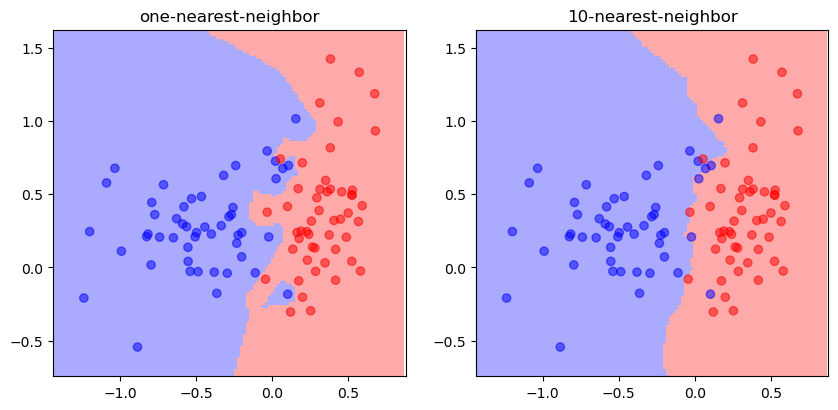

In [4]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                          n_redundant=0, n_repeated=0, n_classes=2, 
                          n_clusters_per_class=1, class_sep=0.35, 
                          random_state=1)

from sklearn.neighbors import KNeighborsClassifier
plt.figure(figsize=(10,4.5))
classifier = KNeighborsClassifier(1)
plot_boundary(classifier, X, y, 2, 1, 'one-nearest-neighbor')

classifier = KNeighborsClassifier(10)
plot_boundary(classifier, X, y, 2, 2, '10-nearest-neighbor')


Next we will see whether the idea of using $k$ nearest neighbors works well in practice using our example breast cancer dataset:

In [5]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y = True)
X.shape, y.shape

((569, 30), (569,))

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, shuffle=True, random_state=1)

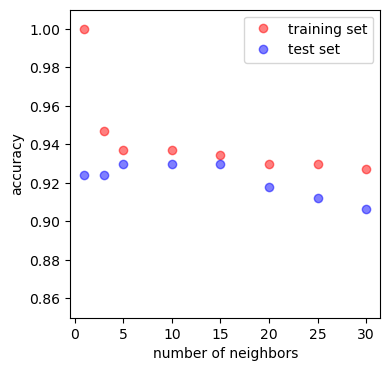

In [7]:
num_neighbors = [1,3,5,10,15,20,25,30]
test_accuracy = []
training_accuracy = []
for k in num_neighbors :
    classifier = KNeighborsClassifier(k, p=2, weights='uniform')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    test_accuracy.append(np.sum(y_pred == y_test)/len(y_test))
    y_pred = classifier.predict(X_train)
    training_accuracy.append(np.sum(y_pred == y_train)/len(y_train))

plt.figure(figsize=(4,4))
plt.plot(num_neighbors, training_accuracy, 'or', alpha=0.5, label = 'training set')
plt.ylim((0.85,1.01))
plt.xlabel('number of neighbors')
plt.ylabel('accuracy');
plt.plot(num_neighbors, test_accuracy, 'ob', alpha=0.5, label = 'test set')
plt.legend();

As we can see, using the k-NN classifier with $k>1$ instead of the one-nearest neighbor leads to improved accuracy, when the number of nearest neighbors is not too large.
For the one-nearest neighbor classifier we clearly see what is called **overfitting**:  perfect accuracy on the training set, and much lower accuracy on the test set.

### Address the following questions:

* Why do we expect the k-NN classifier with $k>1$ to perform better than the one-nearest neighbor classifier?
* In the plot above we see accuracy decrease at some point.  Why is that occurring?

### Distance functions 

The Euclidean distance is one of many ways for computing distance.  Recall that the Euclidean distance is defined by:
$$
d_2(\mathbf{x}, \mathbf{x}')^2 = ||\mathbf{x} - \mathbf{x}'||^2_2 =
(\mathbf{x} - \mathbf{x}')^\top (\mathbf{x} - \mathbf{x}') = 
\sum_{i=1}^d (x_i - x_i')^2,
$$
where $||\cdot||_2$ is the standard Euclidean norm of a vector, aka as the $L_2$ norm.

The **Manhattan distance** is another common distance function that derives from the $L_1$ norm:
$$
d_1(\mathbf{x}, \mathbf{x}') = ||\mathbf{x} - \mathbf{x}'||_1 =
\sum_{i=1}^d |x_i - x_i'|,
$$
where $|x|$ is the absolute value.

The **Minkowski distance** is a generalization of both of these distances.  It has a parameter $p\geq 0$ and is defined by:
$$
d_p(\mathbf{x}, \mathbf{x}') = 
\left( \sum_{i=1}^d |x_i - x_i'|^p \right)^{1/p}.
$$

The Euclidean distance is a special case with $p=2$, and is also called the $L_2$ distance; the Manhattan distance is another special case with $p=1$, and is also called the $L_1$ distance.

The Euclidean and Manhattan distances are the most commonly used in machine learning.




<img style="padding: 0px; float:right;" alt="Circles in discrete and continuous taxicab geometry by Qef in public domain" src="https://upload.wikimedia.org/wikipedia/commons/0/08/Manhattan_distance.svg" width="150">

<img style="padding: 10px; float:right;" alt="Taxicab geometry versus Euclidean distance by User:Psychonaut in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/de/TaxicabGeometryCircle.svg" width="150">


### The geometry of the Manhattan distance


Let's talk about circles.  A circle is the set of points that are a fixed distance from its center.  A circle with respect to the $L_1$ distance looks very different than what we think of as a circle.
In fact, as shown on the right, a circle under the Manhattan distance looks like a square!  

For another interesting property consider the two points on the right:  the green line is the shortest path in the Euclidean distance; in the Manhattan distance, the shortest path is not unique, and the blue, green, and yellow paths all have the same distance.

### Question

* What is the equation for the points on a unit circle in two dimensions under the Manhattan distance?  (We know it's a circle for the Euclidean distance!)


The different geometry of the two ways of measuring distance makes their Voronoi diagrams different, which translates to a difference in the shape of the decision boundary.  

<img style="padding: 10px; float:right;" alt="Voronoi diagram by Balu Ertl CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/5/54/Euclidean_Voronoi_diagram.svg" width="300">

<img style="padding: 10px; float:right;" alt="Manhattan distance by Balu Ertl CC BY-SA 1.0" src="https://upload.wikimedia.org/wikipedia/commons/6/6d/Manhattan_Voronoi_Diagram.svg" width="300">



At this point, let's see which distance works better for our example dataset.

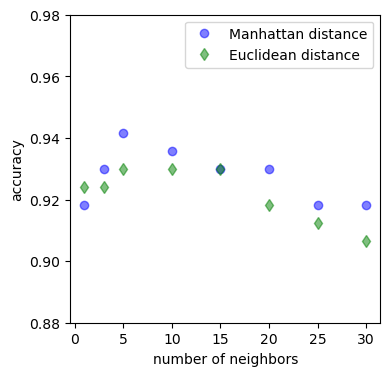

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, shuffle=True, random_state=1)

num_neighbors = [1,3,5,10,15,20,25,30]
accuracy_l1 = []
accuracy_l2 = []
for k in num_neighbors :
    classifier = KNeighborsClassifier(k, p=1, weights='uniform')                              
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_l1.append(np.sum(y_pred == y_test)/len(y_test))

    classifier = KNeighborsClassifier(k, p=2, weights='uniform')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_l2.append(np.sum(y_pred == y_test)/len(y_test))
    
plt.figure(figsize=(4,4))
plt.plot(num_neighbors, accuracy_l1, 'ob', alpha=0.5, label='Manhattan distance')
plt.plot(num_neighbors, accuracy_l2, 'dg', alpha=0.5, label='Euclidean distance')
plt.ylim((0.88, 0.98))
plt.legend()
plt.xlabel('number of neighbors')
plt.ylabel('accuracy');

Based on this plot, you might be tempted to say that the Manhattan distance works better for this dataset.  But try different train-test splits, and this may no longer be the case.